In [346]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.model_selection import cross_val_score 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [347]:
dta =sm.datasets.fair.load_pandas().data
dta['affair'] = (dta.affairs >0).astype(int)

In [348]:
dta.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


In [349]:
dta.describe()


,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374,0.322495
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374,0.467468
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848,1.000000
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991,1.000000


In [350]:
dta.isnull().sum()

rate_marriage      0
age                0
yrs_married        0
children           0
religious          0
educ               0
occupation         0
occupation_husb    0
affairs            0
affair             0
dtype: int64

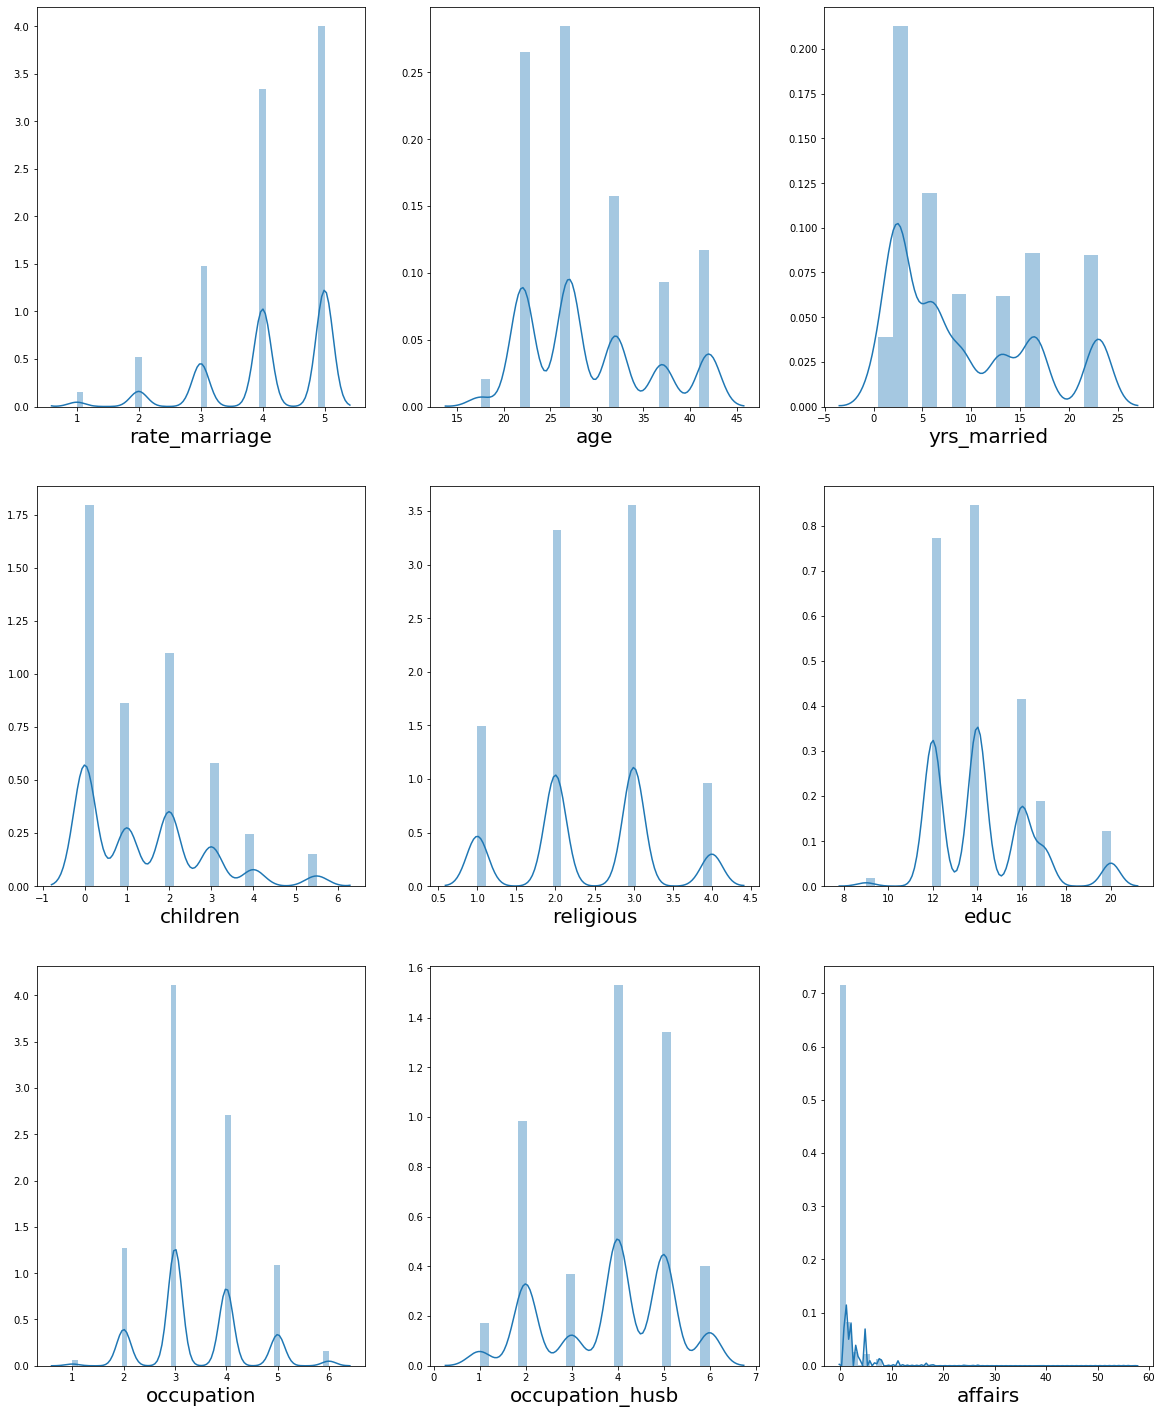

In [294]:
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in dta:
    if plotnumber<=9 :     # as there are 9 columns in the data
        ax = plt.subplot(3,3,plotnumber)
        sns.distplot(dta[column])
        plt.xlabel(column,fontsize=20)
        #plt.ylabel('affair',fontsize=20)
    plotnumber+=1
plt.show()

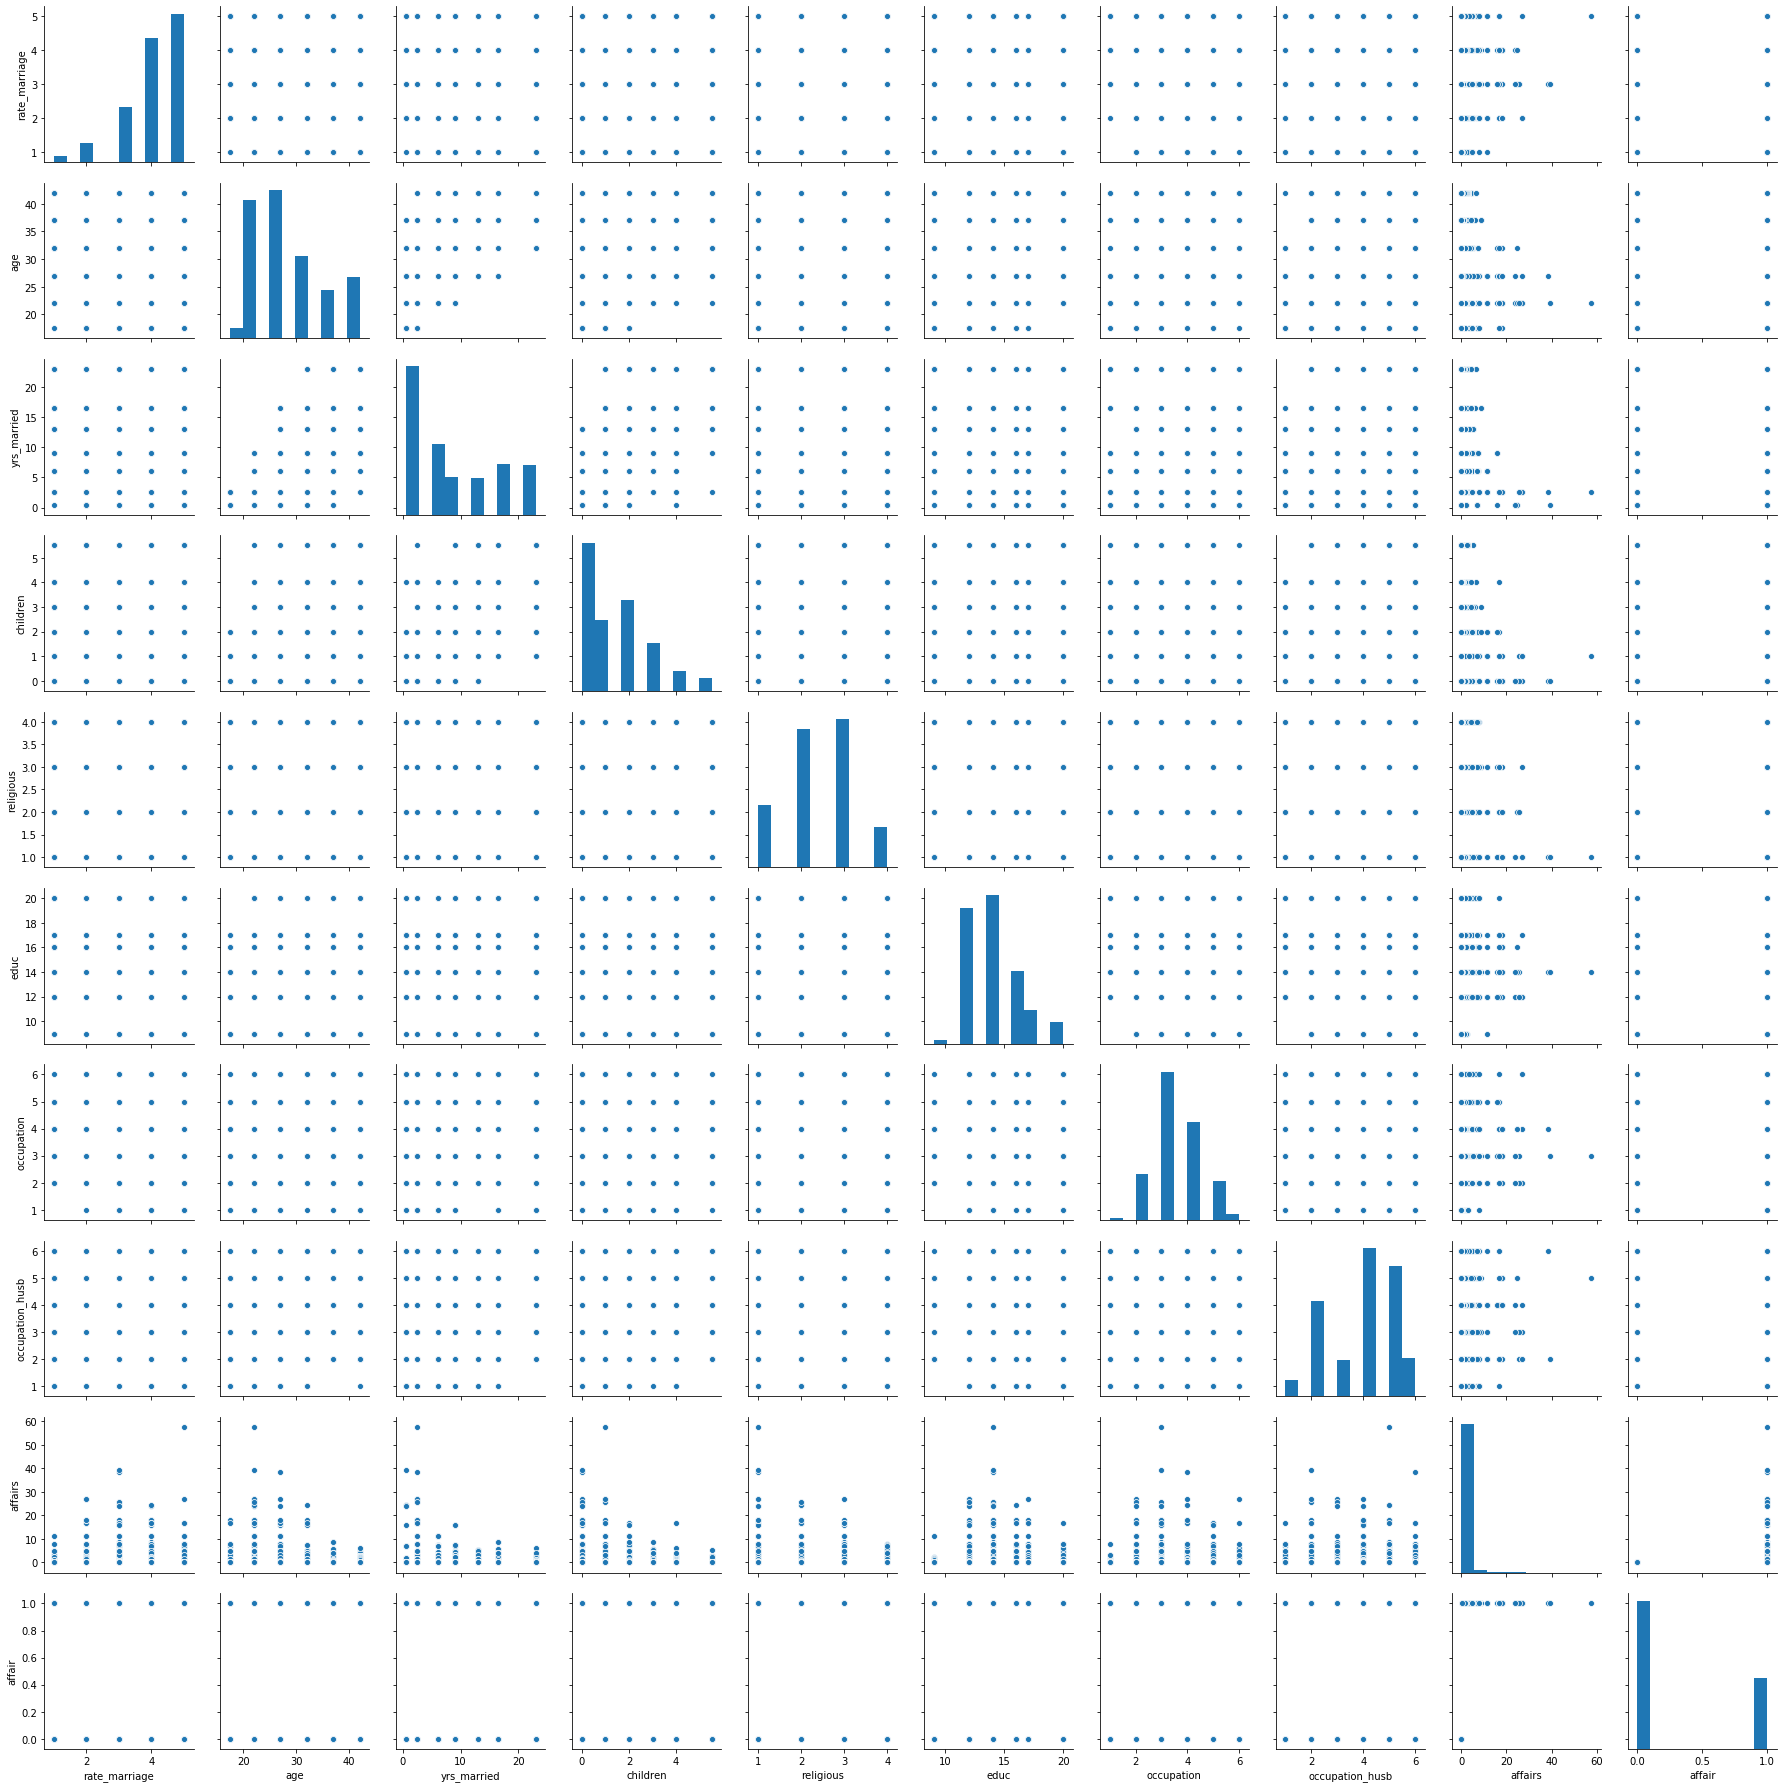

In [295]:
sns.pairplot(dta)

In [351]:
dta.drop(['affairs'],axis=1,inplace=True)

# Co-Relation Matrix

In [352]:
corrmat=dta.corr()
corrmat

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair
rate_marriage,1.000000,-0.111127,-0.128978,-0.129161,0.078794,0.079869,0.039528,0.027745,-0.331776
age,-0.111127,1.000000,0.894082,0.673902,0.136598,0.027960,0.106127,0.162567,0.146519
yrs_married,-0.128978,0.894082,1.000000,0.772806,0.132683,-0.109058,0.041782,0.128135,0.203109
children,-0.129161,0.673902,0.772806,1.000000,0.141845,-0.141918,-0.015068,0.086660,0.159833
religious,0.078794,0.136598,0.132683,0.141845,1.000000,0.032245,0.035746,0.004061,-0.129299
educ,0.079869,0.027960,-0.109058,-0.141918,0.032245,1.000000,0.382286,0.183932,-0.075280
occupation,0.039528,0.106127,0.041782,-0.015068,0.035746,0.382286,1.000000,0.201156,0.028981
occupation_husb,0.027745,0.162567,0.128135,0.086660,0.004061,0.183932,0.201156,1.000000,0.017637
affair,-0.331776,0.146519,0.203109,0.159833,-0.129299,-0.075280,0.028981,0.017637,1.000000


(0, 9)

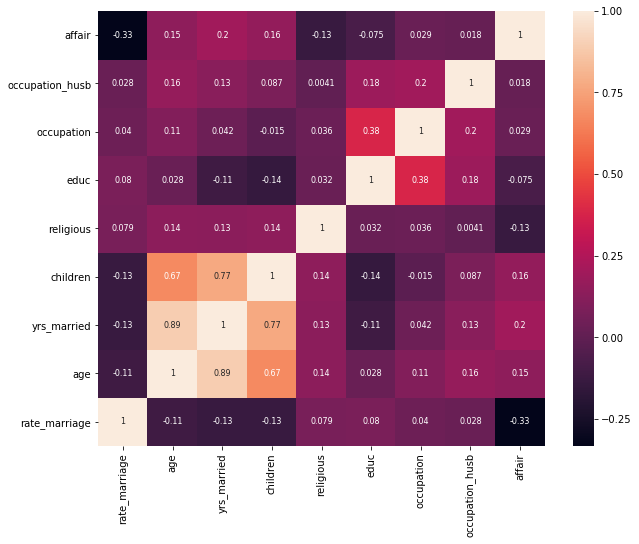

In [353]:
corr = dta.corr()

fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(corr, annot = True, annot_kws={'size': 8})
ax.set_ylim(0 ,9)



# Box Plot

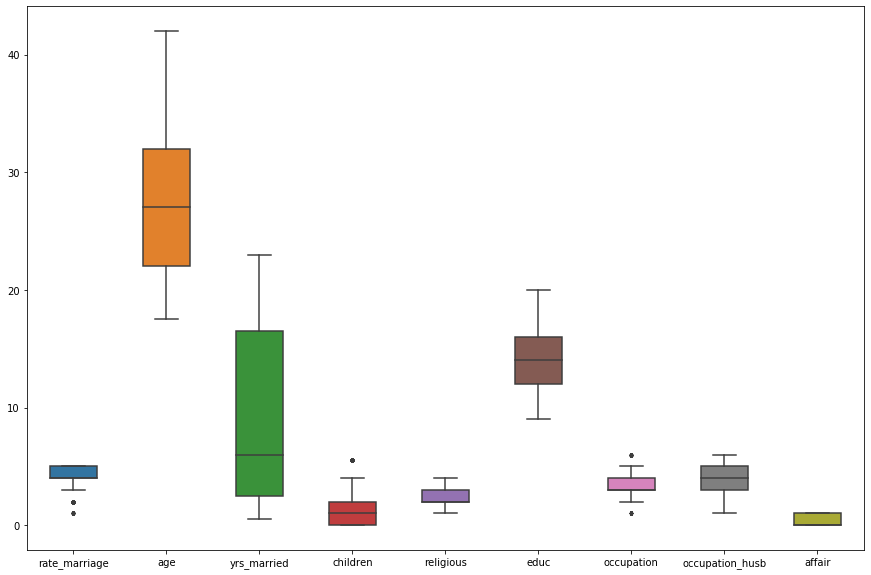

In [354]:

fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=dta, width= 0.5,ax=ax,  fliersize=3)

# Removing Outliers

In [355]:
Q1 = dta.quantile(0.25)
Q3 = dta.quantile(0.75)
IQR= Q3-Q1
IQR

df_out = dta[~((dta < (Q1 - 1.5 * IQR)) |(dta > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df_out.shape)


(5601, 9)


# Finding Co-Related Feature Function


In [357]:
def getCorrelatedFeature(corrdata, threshold):
    feature = []
    value = []
    
    for i, index in enumerate(corrdata.index):
        if abs(corrdata[index])> threshold:
            feature.append(index)
            value.append(corrdata[index])
            
    df = pd.DataFrame(data = value, index = feature, columns=['Corr Value'])
    return df

# Run a Logistic Regression Model

In [385]:
def get_accuracy(custom_data):
    X = custom_data.drop(labels=['affair'], axis = 1)
    y = custom_data['affair']

    X = np.log(X+1)

    scalar = StandardScaler()
    X_scaled = scalar.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 50)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    train_score= model.score(X_train, y_train)
    test_score = model.score(X_test,y_test)
    
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test,y_pred)
    
    conf_mat = confusion_matrix(y_test,y_pred)
    true_positive = conf_mat[0][0]
    false_positive = conf_mat[0][1]
    false_negative = conf_mat[1][0]
    true_negative = conf_mat[1][1]
    Precision = true_positive/(true_positive+false_positive)
    Recall = true_positive/(true_positive+false_negative)
    F1_Score = 2*(Recall * Precision) / (Recall + Precision)
    auc = roc_auc_score(y_test, y_pred)
    
    
    return print("Accuracy: {}\n Precision: {}\n Recall: {}\n F1_Score: {}\n Auc: {}\n ".format(accuracy,Precision,Recall,F1_Score,auc ))
    
    

### Selecting Features that have co relation greater than 1%

In [386]:
threshold = 0.01
corr_value = getCorrelatedFeature(corrmat['affair'], threshold)
corr_value.index.values
correlated_data = df_out[corr_value.index]

In [387]:
get_accuracy(correlated_data)

Accuracy: 0.7341659232827832
 Precision: 0.91875
 Recall: 0.7592975206611571
 F1_Score: 0.8314479638009049
 Auc: 0.5964466510903427
 


/Users/tanvirislamullash/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Selecting Features that have co relation greater than 15%

In [388]:
threshold = 0.15
corr_value = getCorrelatedFeature(corrmat['affair'], threshold)
corr_value.index.values
correlated_data = df_out[corr_value.index]

In [389]:
get_accuracy(correlated_data)

Accuracy: 0.7448706512042819
 Precision: 0.9425
 Recall: 0.7585513078470825
 F1_Score: 0.8405797101449275
 Auc: 0.5974182242990654
 


/Users/tanvirislamullash/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Selecting Features that have co relation greater than 15%

In [390]:
threshold = 0.2
corr_value = getCorrelatedFeature(corrmat['affair'], threshold)
corr_value.index.values
correlated_data = df_out[corr_value.index]
get_accuracy(correlated_data)

Accuracy: 0.7448706512042819
 Precision: 0.9425
 Recall: 0.7585513078470825
 F1_Score: 0.8405797101449275
 Auc: 0.5974182242990654
 


/Users/tanvirislamullash/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Selecting Features that have co relation greater than 30%

In [391]:
threshold = 0.3
corr_value = getCorrelatedFeature(corrmat['affair'], threshold)
corr_value.index.values
correlated_data = df_out[corr_value.index]


In [392]:
get_accuracy(correlated_data)

Accuracy: 0.735950044603033
 Precision: 0.90375
 Recall: 0.767515923566879
 F1_Score: 0.8300803673938003
 Auc: 0.6107535046728972
 


/Users/tanvirislamullash/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [203]:
new_dataset.drop(['age','children','religious','educ','occupation','occupation_husb'],axis=1,inplace=True)

In [367]:
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                  religious + educ + C(occupation) + C(occupation_husb)',
                  df_out, return_type="dataframe")
# print X.columns

# rename column names for the dummy variables for better looks:
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

# and flatten y into a 1-D array so that scikit-learn will properly understand it as the response variable.
y = np.ravel(y)

In [368]:
data_log_transform = np.log(X+1)


/Users/tanvirislamullash/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/tanvirislamullash/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


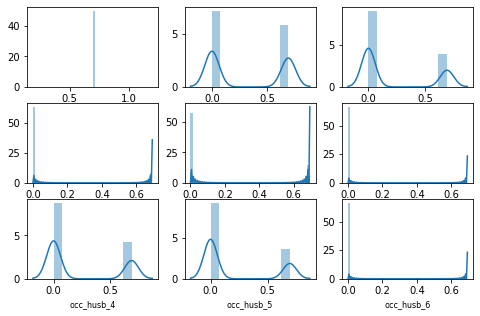

In [314]:
plt.figure(figsize=(8,5), facecolor='white')
plotnumber = 1

for column in data_log_transform:
    if plotnumber<=9 :     # as there are 9 columns in the data
        ax = plt.subplot(3,3,plotnumber)
        sns.distplot(data_log_transform[column])
        plt.xlabel(column,fontsize=8)
        #plt.ylabel('affair',fontsize=20)
    plotnumber+=1
plt.show()

In [369]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_scaled = scalar.fit_transform(data_log_transform)



In [370]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif["Features"] = X.columns

#let's check the values
vif

,vif,Features
0,1.000000,Intercept
1,2.511821,occ_3
2,2.871914,occ_4
3,1.778402,occ_5
4,5.355787,occ_husb_2
5,2.913946,occ_husb_3
6,6.729622,occ_husb_4
7,6.331817,occ_husb_5
8,2.897551,occ_husb_6
9,1.033521,rate_marriage


In [374]:
X_scaled=np.delete(X_scaled, [2,4,6], axis=1)

# Cross Validation Score

In [375]:
scores = cross_val_score(LogisticRegression(), X_scaled, y, scoring='accuracy', cv=10)

print (scores.mean())

0.7311379324050321


/Users/tanvirislamullash/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tanvirislamullash/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tanvirislamullash/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tanvirislamullash/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tanvirislamullash/opt/anaconda3/lib/python3.7/site-packages/sklearn/linea

# Train Test Split Score

In [395]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=10)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)

conf_mat = confusion_matrix(y_test,y_pred)
true_positive = conf_mat[0][0]
false_positive = conf_mat[0][1]
false_negative = conf_mat[1][0]
true_negative = conf_mat[1][1]
Precision = true_positive/(true_positive+false_positive)
Recall = true_positive/(true_positive+false_negative)
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
auc = roc_auc_score(y_test, y_pred)
    
    
print("Accuracy: {}\n Precision: {}\n Recall: {}\n F1_Score: {}\n Auc: {}\n ".format(accuracy,Precision,Recall,F1_Score,auc ))

/Users/tanvirislamullash/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.7368421052631579
 Precision: 0.9224904701397713
 Recall: 0.75625
 F1_Score: 0.8311390955924441
 Auc: 0.6109458338722807
 
